# Week 1 - Tasks

- **Data Source:** `yfinance`
- **Assets:** `AAPL`, `MSFT`, `GOOG`, `AMZN`, `TSLA` (and `NVDA` for Task 5)
- **Timeframes:**
  * **Long Term:** `start="2015-01-01", end="2024-01-01"`
  * **Medium Term:** `start="2020-01-01", end="2024-01-01"` (Includes COVID crash)

The goal for this week is to gain familiarity with financial data, analyze common trends, learn standard library functions, and touch upon the underlying theory.

## Task 1 - Setup
* Fetch **Long Term** historical data for the 5 assets.
* Extract the `Adjusted Close` values.
    * *Note: Check for missing values or empty rows and handle them (drop or fill).*
* Use `df.describe()` to extract key summary statistics.
* Extract the **Medium Term** data as well for later tasks.

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
tickers = ["AAPL", "MSFT", "AMZN", "GOOG", "TLT"]
long_data = yf.download(tickers, start="2015-01-01", end="2024-01-01", auto_adjust=False)
long_adj_close = long_data['Adj Close']

[*********************100%***********************]  5 of 5 completed


In [4]:
long_adj_close = long_adj_close.ffill().bfill()
# print(adj_close)

In [5]:
long_desc = long_adj_close.describe()
print(long_desc)

Ticker         AAPL         AMZN         GOOG         MSFT          TLT
count   2264.000000  2264.000000  2264.000000  2264.000000  2264.000000
mean      81.394710    91.950540    73.063479   154.516907   106.098334
std       55.990879    48.654536    36.298158    99.658478    15.868756
min       20.604073    14.347500    24.377235    34.437168    75.667328
25%       32.814688    44.303625    41.515254    59.182484    94.763855
50%       51.220848    90.691998    59.376663   127.528820   100.190731
75%      139.017624   133.230000   104.133987   244.037380   118.043648
max      196.256561   186.570496   149.587067   377.077850   146.503448


In [6]:
mid_data = yf.download(tickers, start="2020-01-01", end="2024-01-01", auto_adjust=False)
mid_adj_close = mid_data['Adj Close']
mid_adj_close = mid_adj_close.ffill().bfill()

[*********************100%***********************]  5 of 5 completed


## Task 2 - Basic Trends
* Select **one asset** and using the **Medium Term** data, compute:
    * **Returns:** 1-day, 5-day, and 20-day simple returns.
    * **Log Returns:** 1-day, 5-day, and 20-day log returns.
    * **Volatility:** 5-day, 20-day, and 60-day rolling standard deviation (volatility) of the log returns.
* **Plotting:**
    * Plot the price and the 20-day moving average on one chart.
    * Plot the 1-day log returns on a separate chart.
    * Plot the rolling volatilities on a third chart.
    * *Analysis:* What trends do you observe? Does high volatility correlate with price drops?

* **Bonus (Long Term Data):**
    * Create a scatter plot of `|Daily Return|` vs `Volume`. Is there a relationship?
    * Group returns and volatility by **Month** (e.g., all Januaries, all Februaries) and plot the averages. Is there a "seasonal" effect?

In [7]:
goog = mid_data.xs("GOOG", axis=1, level=1)
# print(data)

returns = {}
# print(goog.columns)

price = goog['Adj Close']
returns["1d"] = price.pct_change(1).dropna()
returns["5d"] = price.pct_change(5).dropna()
returns["20d"] = price.pct_change(20).dropna()

# for k, v in returns.items():
#     print(f"{k} return = {v}")


In [8]:
log_price = np.log(price)

log_returns = {}
log_returns["1d"] = log_price.diff(1).dropna()
log_returns["5d"] = log_price.diff(5).dropna()
log_returns["20d"] = log_price.diff(20).dropna()

# for k, v in log_returns.items():
#     print(f"{k} log return: \n{v}")

In [9]:
logret = log_price.diff().dropna()

vol = {}
vol["5d"] = logret.rolling(5).std().dropna()
vol["20d"] = logret.rolling(20).std().dropna()
vol["60d"] = logret.rolling(60).std().dropna()

# for k, v in vol.items():
#     print(f"{k} volatility: \n{v}")

### Plots

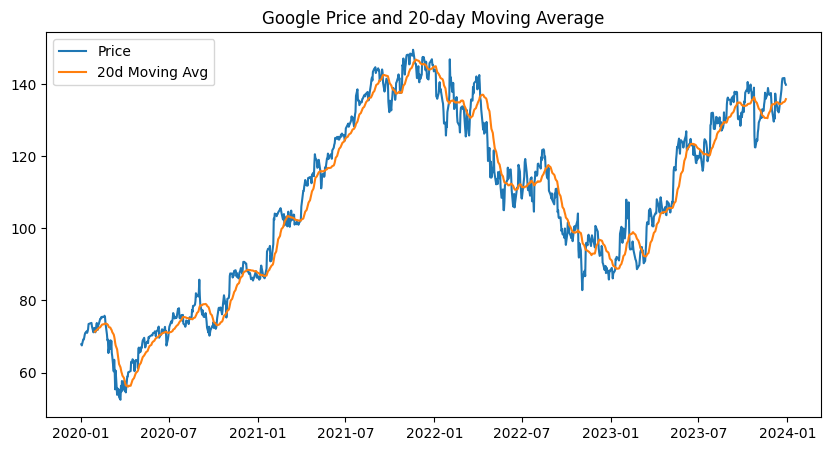

In [10]:
mov_avg_20 = price.rolling(20).mean().dropna()

plt.figure(figsize=(10,5))
plt.plot(price, label="Price")
plt.plot(mov_avg_20, label="20d Moving Avg")
plt.title("Google Price and 20-day Moving Average")
plt.legend()
plt.show()

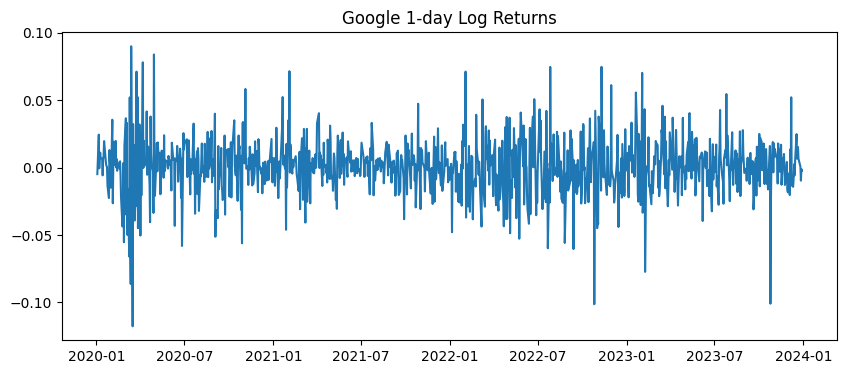

In [11]:
plt.figure(figsize=(10,4))
plt.plot(log_returns["1d"])
plt.title("Google 1-day Log Returns")
plt.show()

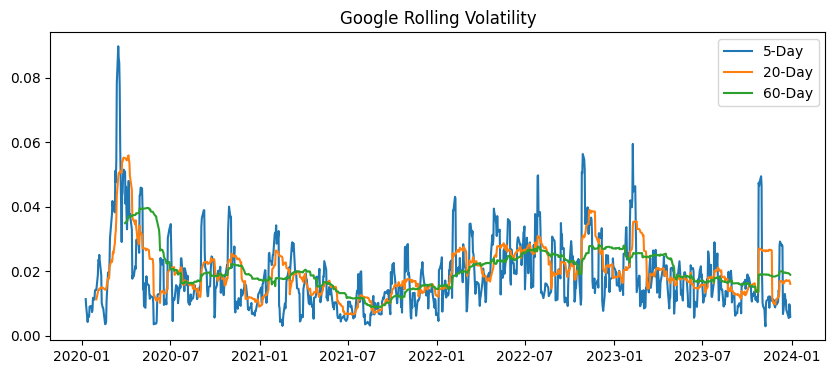

In [12]:
plt.figure(figsize=(10, 4))
plt.plot(vol["5d"], label="5-Day")
plt.plot(vol["20d"], label="20-Day")
plt.plot(vol["60d"], label="60-Day")
plt.title("Google Rolling Volatility")
plt.legend()
plt.show()

### Analysis

- The price series shows periods of sustained upward and downward trends.
- The 20-day moving average smooths short-term noise
- Log return fluctuates around 0. Large positive or negative spikes correspond to large changes in stock price
- Short-window volatility reacts very quickly to sudden rise or drop in prices whereas long-window volatility is smoother and reflects broader risks
- We can observe that high volatility does indeed correlate with price drops as wherever there is a spike in the 5-day volatility of the volatility graph, there is a spike at the same time frame in the log return graph indicating severe price change.

## Task 3 - Stationarity
* Select **one asset** (Long Term).
* Compute the **Rolling Mean** and **Rolling Standard Deviation** of log returns with window sizes `20, 60, 120`.
* Plot them and visually inspect.
    * Does the mean stay constant? (Stationary mean)
    * Does the variance stay constant? (Stationary variance)
* Run an **Augmented Dickey-Fuller (ADF) Test** on the log return series.
    * Library: `from statsmodels.tsa.stattools import adfuller`
    * *Goal:* Interpret the p-value. The Null Hypothesis ($H_0$) is that the series is non-stationary (has a unit root). If p-value < 0.05, we reject $H_0$.
    * For learning about hypothesis testing and p-value you can refer to CS215 slides or other standard resources mentioned in READMEs.

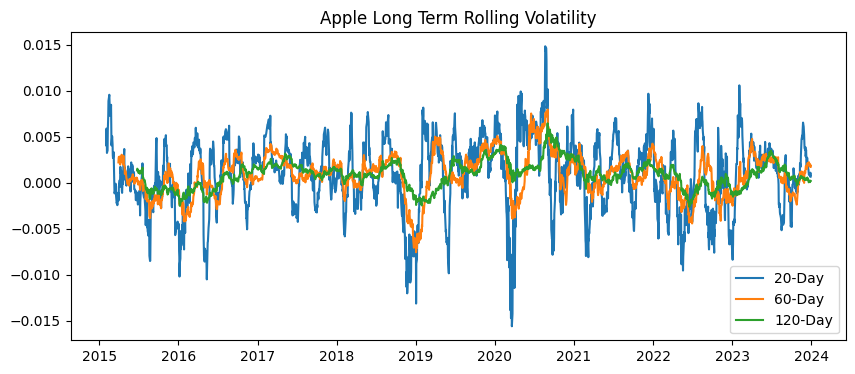

In [16]:
aapl = long_data.xs("AAPL", axis=1, level=1)
price = aapl['Adj Close']

log_price = np.log(price)
logret = log_price.diff().dropna()

window_sizes = [20, 60, 120]
roll_mean = {}
roll_std = {}
for w in window_sizes:
    rm = logret.rolling(w).mean().dropna()
    roll_mean[f"{w}d"] = rm

    rstd = logret.rolling(w).std().dropna()
    roll_std[f"{w}d"] = rstd

plt.figure(figsize=(10,4))
plt.plot(roll_mean["20d"], label="20-Day")
plt.plot(roll_mean["60d"], label="60-Day")
plt.plot(roll_mean["120d"], label="120-Day")
plt.title("Apple Long Term Rolling Volatility")
plt.legend()
plt.show()

### Observations

- Rolling mean fluctuates aound 0
- Larger windows are smoother whereas shorter windows are much more turbulent
- No consistent upward or downward pattern
- Hence, mean is approximately stationary

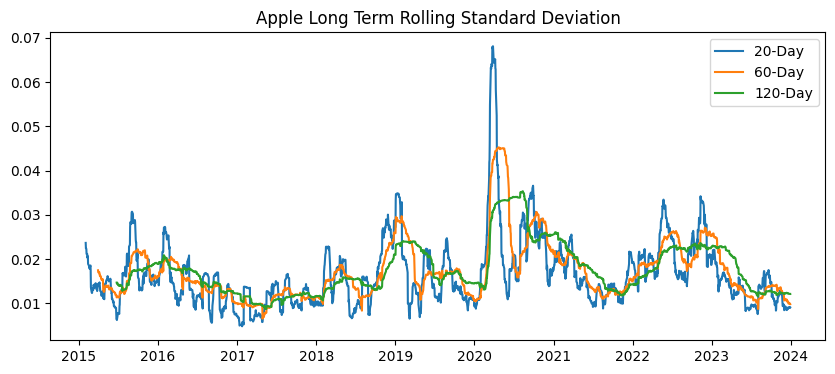

In [17]:
plt.figure(figsize=(10,4))
plt.plot(roll_std["20d"], label="20-Day")
plt.plot(roll_std["60d"], label="60-Day")
plt.plot(roll_std["120d"], label="120-Day")
plt.title("Apple Long Term Rolling Standard Deviation")
plt.legend()
plt.show()

### Observations

- Rolling standard deviation varies a lot (relatively) with time
- There are sudden spikes and drops 
- Hence, the variance is not stationary

### Augmented Dickey-Fuller Test

In [ ]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(logret)

adf_stat = adf_result[0]
p_val = adf_result[1]

print(f"ADF Statistic: {adf_stat:.4f}")
print(f"P Value: {p_val}")

ADF Statistic: -14.7153
P Value: 2.8065305893420442e-27


### Conclusion

The null hypothesis **H<sub>0</sub>** states that the series is non-stationary. The alternate hypothesis **H<sub>1</sub>** is that the series is stationary. Since our observed `p value` is much lesser than 0.05, we reject the null hypothesis and accept the alternate hypothesis. Hence, the series is **stationary**.

## Task 4 - Volatility Regimes
We try to study the trend in volatility more deeply. From the ACF/PACF plot we know that volatility tends to cluster that is the market is either in a high volatility state (greater daily fluctuations) or low volatility state (stable prices, quiet markets).

Formally we can treat volatility as a *conditional standard deviation of returns*, conditioned on the history observed so far. We *cannot* predict *true* volatility for a given day based on the single return value, hence we try to estimate it using the past information. For this we look at two indicators of volatility:

1.  **Rolling Window Volatility:** Simple Moving Average (SMA) of standard deviation.
2.  **EWMA Volatility:** Exponentially Weighted Moving Average. This gives more weight to recent events. It is given by $\sigma_t^2 = (1-\lambda)r_t^2 + \lambda \sigma_{t-1}^2$.

**Steps:**
* Pick an asset and use data covering the **Feb-Mar 2020 COVID crash**.
* Compute two volatility estimates on the Log Returns:
    1.  **Rolling 20-day Volatility:** Standard deviation over a 20-day window.
    2.  **EWMA Volatility (RiskMetrics):** Use a decay factor $\lambda = 0.94$.
        * *Hint:* In pandas `df.ewm()`, the parameter `alpha` corresponds to $1 - \lambda$. So, use `alpha=0.06`.
* **Analysis:**
    * Plot both estimates on the same chart.
    * Which is smoother?
    * Which estimator reacts faster to the sudden crash in March 2020?
    * Which one would you prefer for risk management?
* **Regime Detection:** Compute the 60th percentile of your EWMA volatility series. Shade the regions on the plot where volatility exceeds this level.

* **Bonus:** A good volatility model "standardizes" the returns well. Calculate $z_t = r_t / \hat{\sigma}_t$. If the model is good, $z_t$ should have $Var \approx 1$. Check the variance of $z_t$ and plot its histogram.

In [32]:
amzn = long_data.xs("AMZN", axis=1, level=1)
amzn = yf.download("AMZN", start="2019-01-01", end="2020-12-31", auto_adjust=False)
price = amzn['Adj Close']
logret = np.log(price).diff().dropna()

roll_20d_vol = logret.rolling(20).std().dropna()

alpha = 0.06
ewma_var = logret.pow(2).ewm(alpha=alpha, adjust=False).mean()
ewma_vol = np.sqrt(ewma_var)

[*********************100%***********************]  1 of 1 completed

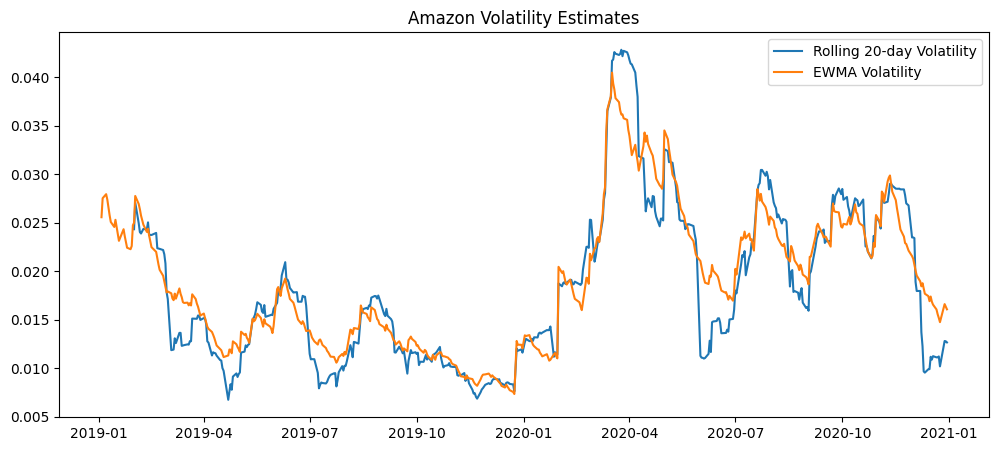

In [33]:
plt.figure(figsize=(12,5))

plt.plot(roll_20d_vol, label="Rolling 20-day Volatility")
plt.plot(ewma_vol, label="EWMA Volatility")
plt.title("Amazon Volatility Estimates")
plt.legend()
plt.show()

#### Analysis

- The EWMA volatility is smoother than 20-day rolling volatility.
- EWMA volatility reacts faster since it places higher weight on recent squared returns, whereas rolling volatility gives the same weight for all the returns in the 20 day window.
- EWMA volatility would be preferred for risk management as it "adapts" quicker to sudden changes in the market as it's a weighted exponential average with higher weights to more recent returns. Hence, we can observe changes faster and react quickly w.r.t risk management.

### Regime Detection

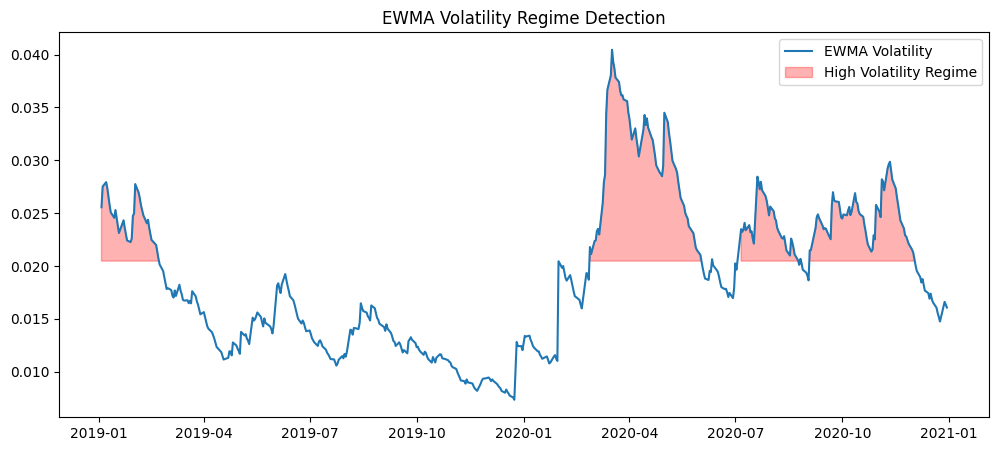

In [36]:

plt.figure(figsize=(12, 5))
plt.plot(ewma_vol, label="EWMA Volatility")

ewma_vol_1d = ewma_vol.squeeze()

threshold = float(ewma_vol_1d.quantile(0.60))


plt.fill_between(
    ewma_vol_1d.index,
    ewma_vol_1d.values,
    threshold,
    where=(ewma_vol_1d.values > threshold),
    color="red",
    alpha=0.3,
    label="High Volatility Regime"
)

plt.title("EWMA Volatility Regime Detection")
plt.legend()
plt.show()

## Task 5 - Time Horizons and the "Normal" Illusion
Short-term markets are noisy and dangerous (fat tails), while long-term data looks smoother. We can prove this statistically using **Skew** and **Kurtosis**.

**Theory:**
* **Skewness:** Measures asymmetry. (Negative skew = frequent small gains, few extreme losses).
* **Kurtosis:** Measures "tailedness". (High kurtosis = frequent extreme events/crashes).
* **Normal Distribution:** Skew $\approx 0$, Kurtosis $\approx 3$ (or Excess Kurtosis $\approx 0$).

**Steps:**
1.  Take your **Long Term** data for one asset (e.g., NVDA or TSLA).
2.  Resample the prices to get **Weekly** and **Monthly** closes.
    * Use `df['Adj Close'].resample('W').last()` and `...resample('M').last()`.
3.  Compute Log Returns for all three series: Daily, Weekly, Monthly.
4.  **The Test:**
    * Calculate **Skew** and **Kurtosis** for each of the three return series.
    * *Question:* How do these values change as the time horizon increases? Do they get closer to 0 and 3?
5.  **Visualization:**
    * Plot the **Histograms** of the Daily returns vs. Monthly returns on the same plot.
    * *Tip:* You will need to standardize them (subtract mean, divide by std dev) to overlay them meaningfully.
    * *Observation:* Look at the tails. Which one has "fatter" tails (more extreme outliers)?

**Key Takeaway:**
Daily returns often violate the "Normal Distribution" assumption used in many financial models. Long-term returns fit it better. This is called *Aggregational Gaussianity*.

**Bonus:** This is a direct application of a simple yet well-known result in asymptotic statistics. Can you find out what it is and state how it explains this observation?

In [39]:
nvda = yf.download("NVDA", start="2015-01-01", end="2024-01-01", auto_adjust=False)
price = nvda['Adj Close']

weekly = price.resample('W').last()
monthly = price.resample('ME').last()

[*********************100%***********************]  1 of 1 completed


In [ ]:
logret_daily = np.log(price).diff().dropna()
logret_weekly = np.log(weekly).diff().dropna()
logret_monthly = np.log(monthly).diff().dropna()


### Skew and Kurtosis Calculation

In [47]:
from scipy.stats import skew, kurtosis

daily_skew = skew(logret_daily)
daily_kurt = kurtosis(logret_daily, fisher=False)

weekly_skew = skew(logret_weekly)
weekly_kurt = kurtosis(logret_weekly, fisher=False)

monthly_skew = skew(logret_monthly)
monthly_kurt = kurtosis(logret_monthly, fisher=False)

print(f"Daily Skew: {daily_skew}; Daily Kurtosis: {daily_kurt}")
print(f"Weekly Skew: {weekly_skew}; Weekly Kurtosis: {weekly_kurt}")
print(f"Monthly Skew: {monthly_skew}; Monthly Kurtosis: {monthly_kurt}")

Daily Skew: [0.2098671]; Daily Kurtosis: [10.51279954]
Weekly Skew: [0.10213107]; Weekly Kurtosis: [4.36378771]
Monthly Skew: [-0.55256024]; Monthly Kurtosis: [3.60216489]


### Analysis

These values move closer to 0 and 3 for **skew** and **kurtosis** respectively as the time frame increases. This is because as we take a larger time span, the distribution tends to become more symmetric and less heavy-tailed

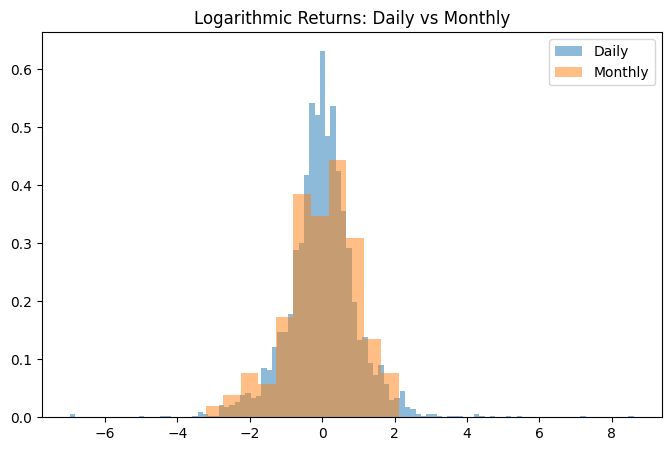

In [49]:
daily_std = (logret_daily - logret_daily.mean()) / logret_daily.std()
monthly_std = (logret_monthly - logret_monthly.mean()) / logret_monthly.std()

plt.figure(figsize=(8, 5))
plt.hist(daily_std, bins='fd', density=True, alpha=0.5, label="Daily")
plt.hist(monthly_std, bins='fd', density=True, alpha=0.5, label="Monthly")

plt.title("Logarithmic Returns: Daily vs Monthly")
plt.legend()
plt.show()

### Analysis

- Daily returns have much sharper and taller peak around 0. Daily returns are more concentrated around the mean.
- Monthly returns are flatter. This means that monthly returns are smoother and more spread out.
- Daily returns have fatter tails. This means that they produce more extreme outcomes.
- Monthly returns have thinner tails. It decays faster than daily returns

## Task 6 - Smart investing
Calculate how many **RTX 4090s** (approx. price $1,600$) you could afford *today* if you had invested **$1,000** in NVIDIA on the day you were born.

In [65]:
nvda = yf.download("NVDA", start="2005-01-01", end="2025-12-13", auto_adjust=False)
old_price = nvda.loc["2005-12-08", "Adj Close"].item()
print(f"Buy price (Adj Close 8th Dec, 2005): {old_price:.4f}") # Yes I'm already 20 :(
curr_price = nvda["Adj Close"].iloc[-1].item()
print(f"Latest price (Adj Close 13th Dec, 2025): {curr_price:.4f}")
final_val = 1000 * (curr_price/old_price)
print(f"Final value of investment: {final_val:.3f}")
numRtx = final_val//1600
print(f"Number of RTX 4090s: {numRtx:.0f}")


[*********************100%***********************]  1 of 1 completed

Buy price (Adj Close 8th Dec, 2005): 0.2738
Latest price (Adj Close 13th Dec, 2025): 175.0200
Final value of investment: 639339.750
Number of RTX 4090s: 399


### Final Answer

Number of RTX 4090s I can afford today is **399**